## XGBOOST

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
import matplotlib.dates as mdates
import pickle
from datetime import timedelta
import os

##### Read data

In [56]:
df = pd.read_csv("TransformedData.csv")
df['Posted Time'] = pd.to_datetime(df['Posted Time'], format="%d/%m/%Y")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (20937, 34)


,Posted Time,Longitude,Latitude,Area,Width,Length,Floors,Rooms,Toilets,Price per m2,...,House Direction_SOUTHWEST,House Direction_WEST,Furnishing Sell_BASIC_FINISHING,Furnishing Sell_FULLY_FURNISHED,Furnishing Sell_HIGH_END_FURNITURE,Furnishing Sell_RAW_HANDOVER,Land Type_AGRICULTURAL_LAND,Land Type_INDUSTRIAL_LAND,Land Type_PROJECT_LAND,Land Type_RESIDENTIAL_LAND
0,2025-01-31,10.400602,4.003590,10.000000,2.236068,4.472136,0.0,0.0,0.0,1.581139,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2025-02-01,10.398891,4.009621,10.000000,2.236068,4.472136,0.0,0.0,0.0,1.581139,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2025-01-13,10.399521,4.008289,8.660254,2.236068,3.872983,0.0,0.0,0.0,1.932184,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2025-02-07,10.400602,3.996527,12.369317,2.236068,5.477226,0.0,0.0,0.0,1.646942,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2025-02-02,10.397751,4.005646,10.000000,2.236068,4.472136,0.0,0.0,0.0,2.236068,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


#### Create time feature

In [57]:
df['year']      = df['Posted Time'].dt.year
df['month']     = df['Posted Time'].dt.month
df['day']       = df['Posted Time'].dt.day
df['dayofweek'] = df['Posted Time'].dt.dayofweek
df['quarter']   = df['Posted Time'].dt.quarter
# Mùa xuân (tháng 1-3), Mùa hè (tháng 4-6), Mùa thu (tháng 7-9), Mùa đông (tháng 10-12)
# season_dict = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2, 10: 3, 11: 3, 12: 3}
# df['season'] = df['month'].map(season_dict)

df.drop(columns=['Posted Time'], inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20937 entries, 0 to 20936
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Longitude                           20937 non-null  float64
 1   Latitude                            20937 non-null  float64
 2   Area                                20937 non-null  float64
 3   Width                               20937 non-null  float64
 4   Length                              20937 non-null  float64
 5   Floors                              20937 non-null  float64
 6   Rooms                               20937 non-null  float64
 7   Toilets                             20937 non-null  float64
 8   Price per m2                        20937 non-null  float64
 9   1 Part Residential                  20937 non-null  int64  
 10  All Residential                     20937 non-null  int64  
 11  Back Expansion                      20937

#### EDA: Correlation matrix

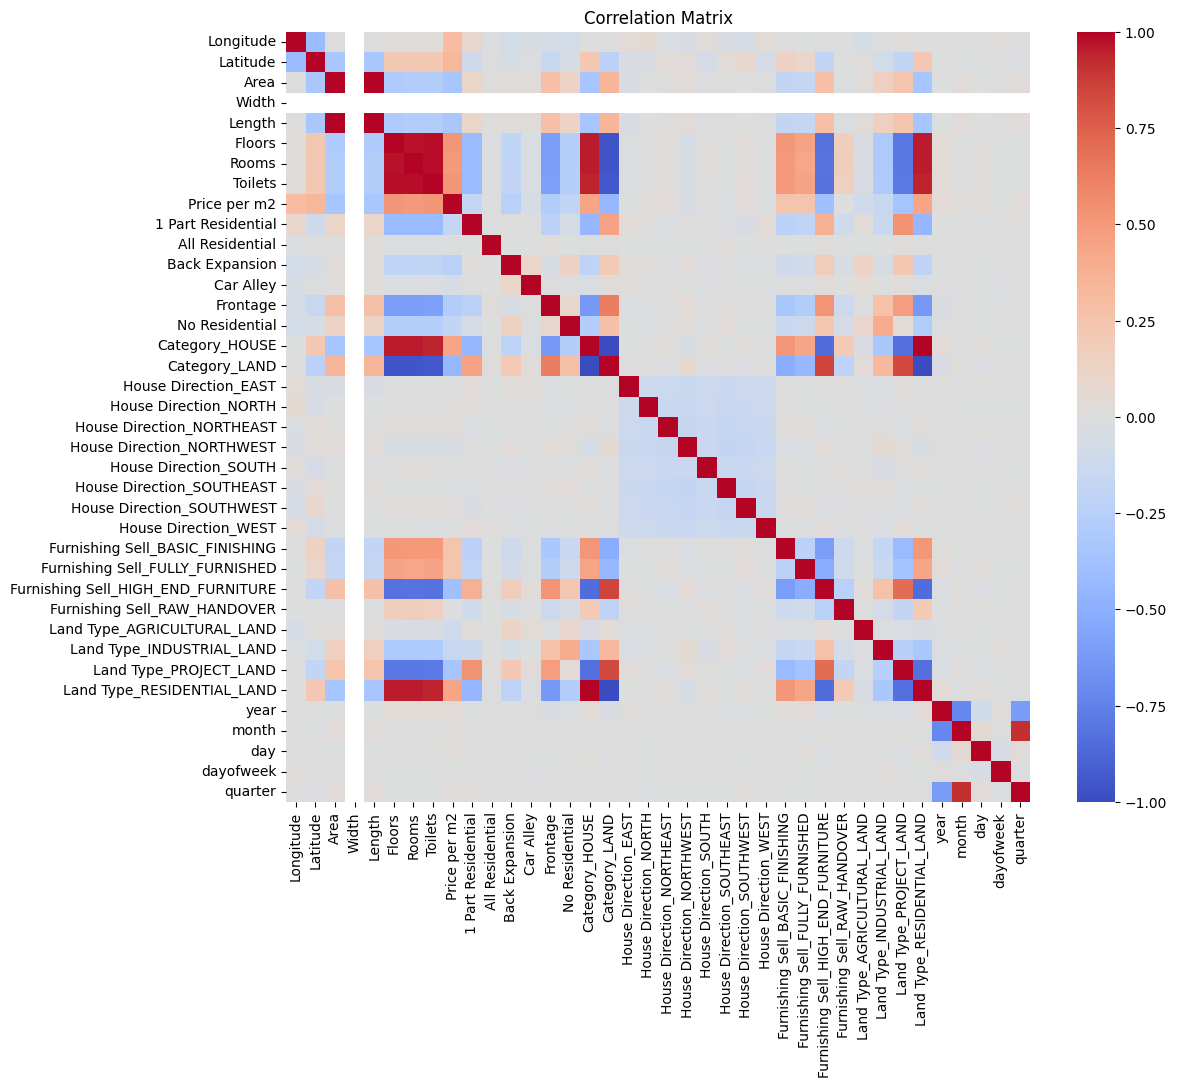

Top 10 features correlated with Price per m2:
 Floors                                0.517523
Toilets                               0.516485
Rooms                                 0.493847
Category_LAND                         0.443516
Category_HOUSE                        0.443516
Land Type_RESIDENTIAL_LAND            0.443516
Furnishing Sell_HIGH_END_FURNITURE    0.389836
Land Type_PROJECT_LAND                0.357008
Area                                  0.345135
Length                                0.342874
Name: Price per m2, dtype: float64


In [58]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix")
plt.show()

corr_with_price = df.corr()['Price per m2'].abs().sort_values(ascending=False).drop('Price per m2')
print("Top 10 features correlated with Price per m2:\n", corr_with_price.head(10))

#### Split data

In [59]:
y = df['Price per m2']
X = df.drop('Price per m2', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=26
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
# train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

# X_train = train.drop('Price per m2', axis=1)
# y_train = train['Price per m2']
# X_test = test.drop('Price per m2', axis=1)
# y_test = test['Price per m2']

# print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (16749, 37), X_test: (4188, 37)


### Train model

In [60]:
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

#### Evaluate

In [61]:
# Evaluate on Training Set
y_train_pred = xgb_reg.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on Test Set
y_test_pred = xgb_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== XGBoost Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.4f}")

=== XGBoost Evaluation ===
Training MSE: 0.63988, RMSE: 0.79992, MAE: 0.55642, R2: 0.8094
Test MSE: 0.75202, RMSE: 0.86719, MAE: 0.59754, R2: 0.7792


#### Scatter actual vs predicted

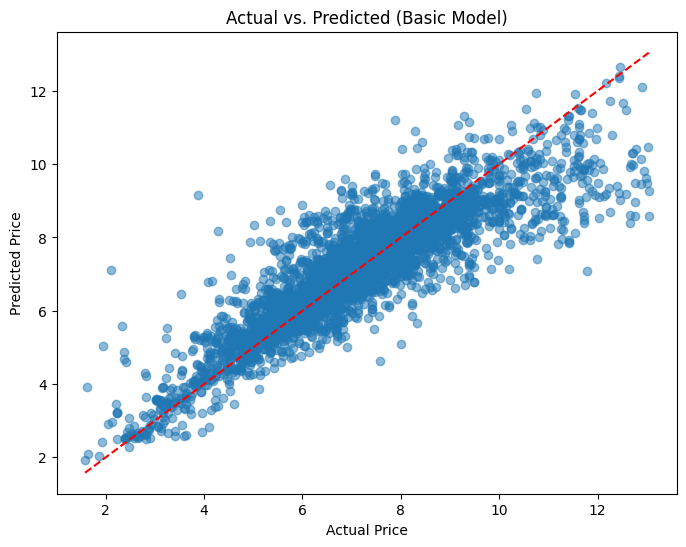

In [62]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted (Basic Model)")
plt.show()

#### Feature importance

<Figure size 800x600 with 0 Axes>

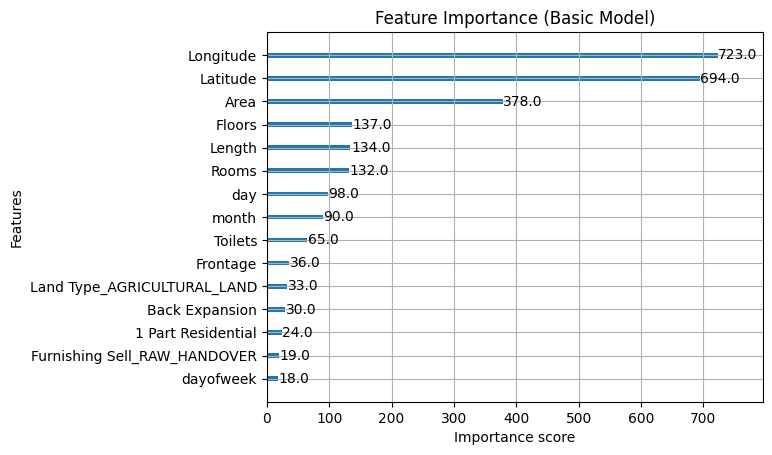

In [63]:
plt.figure(figsize=(8,6))
xgb.plot_importance(xgb_reg, max_num_features=15)
plt.title("Feature Importance (Basic Model)")
plt.show()

#### Hyperparameter tuning

In [64]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': [3, 5, 7, 9],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 1, 5],
# }

# Fitting 2 folds for each of 11250 candidates, totalling 22500 fits
# === Best Configuration for random_state=26 ===
# Lowest MSE: 0.0943
# Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}

param_grid = {
    'n_estimators': [350],
    'learning_rate': [0.05],
    'max_depth': [7],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid = GridSearchCV(
    model, param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_score = -grid.best_score_
best_params = grid.best_params_

print("\n=== Best Configuration ===")
print(f"Lowest MSE: {best_score:.4f}")
print("Best Params:", best_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

=== Best Configuration ===
Lowest MSE: 0.5516
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 350, 'subsample': 0.8}


#### Evaluate optimized model

=== XGBoost Evaluation ===
Training MSE: 0.25334, RMSE: 0.50333, MAE: 0.34957, R2: 0.92453
Test MSE: 0.54831, RMSE: 0.74048, MAE: 0.48660, R2: 0.83901


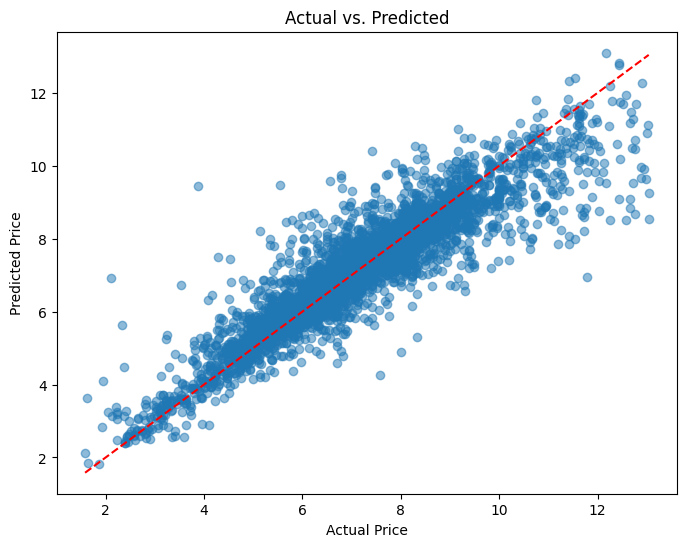

In [65]:
best_model = grid.best_estimator_

y_train_pred = best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on Test Set
y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== XGBoost Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.5f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.5f}")

# Scatter optimal
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted")
plt.show()

#### Error distribution

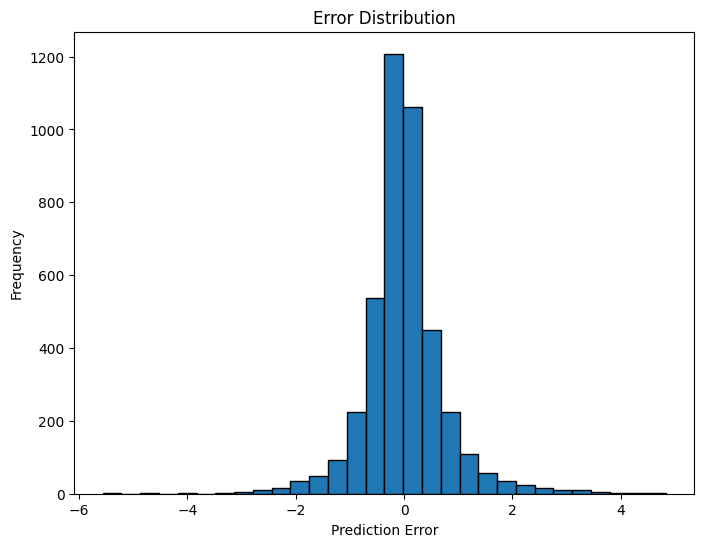


Cross-val MSE mean: 0.55247, std: 0.01510


In [66]:
errors = y_test - y_test_pred
plt.figure(figsize=(8,6))
plt.hist(errors, bins=30, edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.show()

# 11. Cross-validation trên train
cv_scores = cross_val_score(best_model, X_train, y_train,
                            cv=5, scoring='neg_mean_squared_error')
print("\nCross-val MSE mean: {:.5f}, std: {:.5f}".format(-cv_scores.mean(), cv_scores.std()))


#### Fit final model on full dataset

In [67]:
final_model = xgb.XGBRegressor(**grid.best_params_,
                               objective='reg:squarederror',
                               random_state=42)
final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=350,
             n_jobs=None, num_parallel_tree=None, ...)

#### Export model

In [68]:
pipeline = PMMLPipeline([
    ("regressor", final_model)
])

with open('xgboost_final_model.pmml', 'wb') as f:
    pickle.dump(pipeline, f)

with open('xgboost_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("Saved final model to xgboost_final_model.pkl")

Saved final model to xgboost_final_model.pkl


In [69]:
from sklearn.pipeline import Pipeline
from nyoka import xgboost_to_pmml
import os

output_dir = '../../Backend/src/main/resources/'
os.makedirs(output_dir, exist_ok=True)

pipeline = Pipeline([("regressor", final_model)])

pmml_path = os.path.join(output_dir, "xgboost_final_model.pmml")

# (Optional) Xóa file cũ nếu có
if os.path.exists(pmml_path):
    os.remove(pmml_path)

xgboost_to_pmml(pipeline,
                col_names=list(X_train.columns),
                target_name="price",
                pmml_f_name=pmml_path)

In [70]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# season_dict phải khớp với lúc bạn tạo season
# season_dict = {1: 0, 2: 0, 3: 0,
#                4: 1, 5: 1, 6: 1,
#                7: 2, 8: 2, 9: 2,
#                10: 3,11: 3,12: 3}

# Giả sử:
#   - X là DataFrame chứa đầy đủ các feature (đã drop 'Posted Time')
#   - final_model là XGBRegressor đã train trên X, y
# Lấy mẫu baseline (ở đây dùng dòng cuối của X)
base = X.iloc[-1].copy()

# Ngày bắt đầu forecast: hôm nay (chỉ lấy phần date)
start_date = pd.Timestamp.now().normalize()

results = []
for i in range(90):
    date = start_date + timedelta(days=i)
    f = base.copy()
    
    # Cập nhật các feature thời gian
    f['year']      = date.year
    f['month']     = date.month
    f['day']       = date.day
    f['dayofweek'] = date.weekday()
    f['quarter']   = date.quarter
    # f['season']    = season_dict[date.month]
    # Dự đoán
    X_pred = f.values.reshape(1, -1)
    pred_price = final_model.predict(X_pred)[0]
    
    results.append({
        'Date': date,
        'Predicted_Price_per_m2': pred_price
    })

forecast_df = pd.DataFrame(results)

print(forecast_df.head())
print(forecast_df.tail())


        Date  Predicted_Price_per_m2
0 2025-06-12               12.176026
1 2025-06-13               12.169204
2 2025-06-14               12.171313
3 2025-06-15               12.162853
4 2025-06-16               12.188638
         Date  Predicted_Price_per_m2
85 2025-09-05               11.772281
86 2025-09-06               11.784683
87 2025-09-07               11.815945
88 2025-09-08               11.832106
89 2025-09-09               11.801192


### Test model

In [ ]:
# Base input – tạo 1 mẫu gốc
# Bạn cần gán X là DataFrame chứa đúng các cột đã train
base = X.iloc[-1].copy()  # Giả sử bạn vẫn còn biến X

# Ngày bắt đầu forecast
start_date = pd.Timestamp.now().normalize()

results = []
for i in range(90):
    date = start_date + timedelta(days=i)
    f = base.copy()

    # Cập nhật các đặc trưng thời gian
    f['year']      = date.year
    f['month']     = date.month
    f['day']       = date.day
    f['dayofweek'] = date.weekday()
    f['quarter']   = date.quarter
    # f['season']    = season_dict[date.month]  # Nếu dùng

    # Biến thành DataFrame để predict
    X_pred = pd.DataFrame([f])

    # Dự đoán bằng model PMML
    pred_price = model.predict(X_pred).iloc[0, 0]  # hoặc .iloc[0]['Predicted'] tùy tên cột

    results.append({
        'Date': date,
        'Predicted_Price_per_m2': pred_price
    })

forecast_df = pd.DataFrame(results)

print(forecast_df.head())
print(forecast_df.tail())


        Date  Predicted_Price_per_m2
0 2025-06-12               12.176026
1 2025-06-13               12.169204
2 2025-06-14               12.171313
3 2025-06-15               12.162853
4 2025-06-16               12.188638
         Date  Predicted_Price_per_m2
85 2025-09-05               11.772281
86 2025-09-06               11.784683
87 2025-09-07               11.815945
88 2025-09-08               11.832106
89 2025-09-09               11.801192


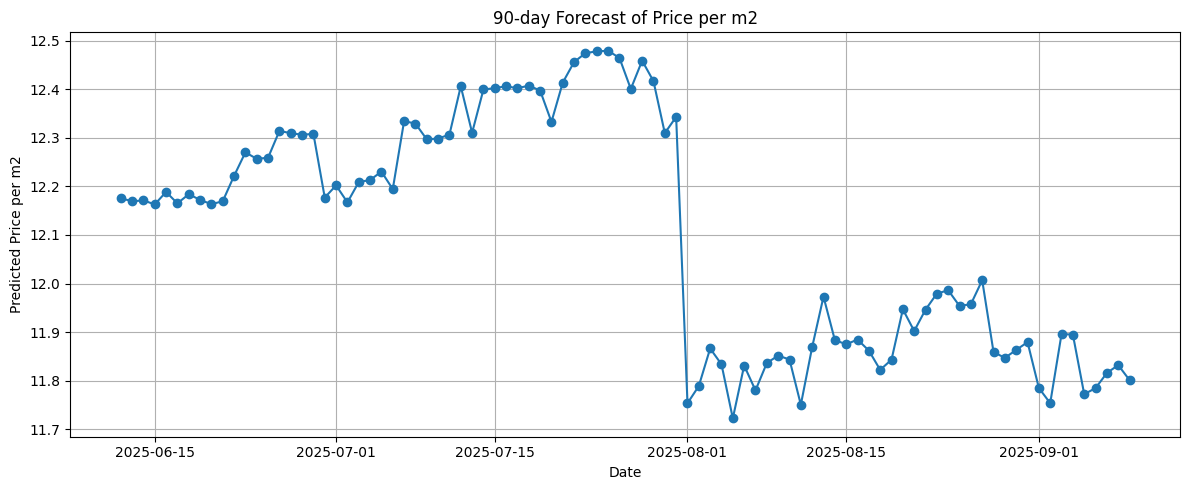

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(forecast_df['Date'], forecast_df['Predicted_Price_per_m2'], marker='o')
plt.title('90-day Forecast of Price per m2')
plt.xlabel('Date')
plt.ylabel('Predicted Price per m2')
plt.grid(True)
plt.tight_layout()
plt.show()